### Using SVD to factorise user-game-matrix and get another representation for users and games

In [168]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from copy import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20 # change to set one

In [170]:
# filter data with the minimum reviews
filtered_avis = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_avis)

11201 10549
1259 1267
904 1158
873 1140
869 1136
868 1135


In [171]:
# see the array without truncation, to truncate, threshold = 0
# np.set_printoptions(threshold=np.inf) 

The function svd compute SVD on array. Svds compute for sparse matrix, we'll check on the singular values returned using the array matrix, to determine the k best singular values to compute using sparse matrix. 

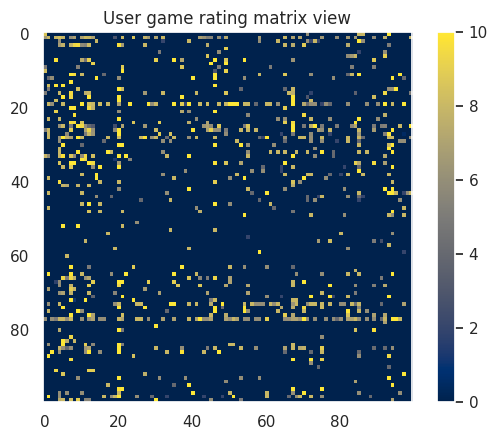

In [172]:
# transforming the matrix as array for svd
mat_ug = user_game_ratings.toarray()
plt.imshow(mat_ug[:100,:100], cmap="cividis")
plt.grid(False)
plt.title("User game rating matrix view")
plt.colorbar()

**SVD matrix**

`U` representation for users: cols = latent features, rows = users profil, index corresponding to mat_ug users

`D` contains the diagonal singular values of diagonal matrix. Represent how much one latent feature in U and V influence mat_ug. D is sorted descending

`Vt` representation for games : rows = latent features, columns = games, index matching mat_ug games

In [173]:
# creating svd matrix such mat_ug = U @ D @ Vt

# U, D, Vt = svd(mat_ug)
# np.save("generated_data/U.npy", U)
# np.save("generated_data/D.npy", D)
# np.save("generated_data/Vt.npy", Vt) 

U, D, Vt = np.load("generated_data/U.npy"), np.load("generated_data/D.npy"), np.load("generated_data/Vt.npy") 

In [174]:
# shape of the matrixes
U.shape, D.shape, Vt.shape, mat_ug.shape

((868, 868), (868,), (1135, 1135), (868, 1135))

In [175]:
# we test to see if we can reconstruct our mat_ug matrix

diag = np.zeros((U.shape[0], Vt.shape[0])) # create the diagonal matrix
np.fill_diagonal(diag, D)

UDVt = U @ diag @ Vt
UDVt.shape, np.allclose(UDVt, mat_ug) # allclose check to a certain threshold if matrixes are similar

((868, 1135), True)

**Visualisation of the decomposed matrix components**

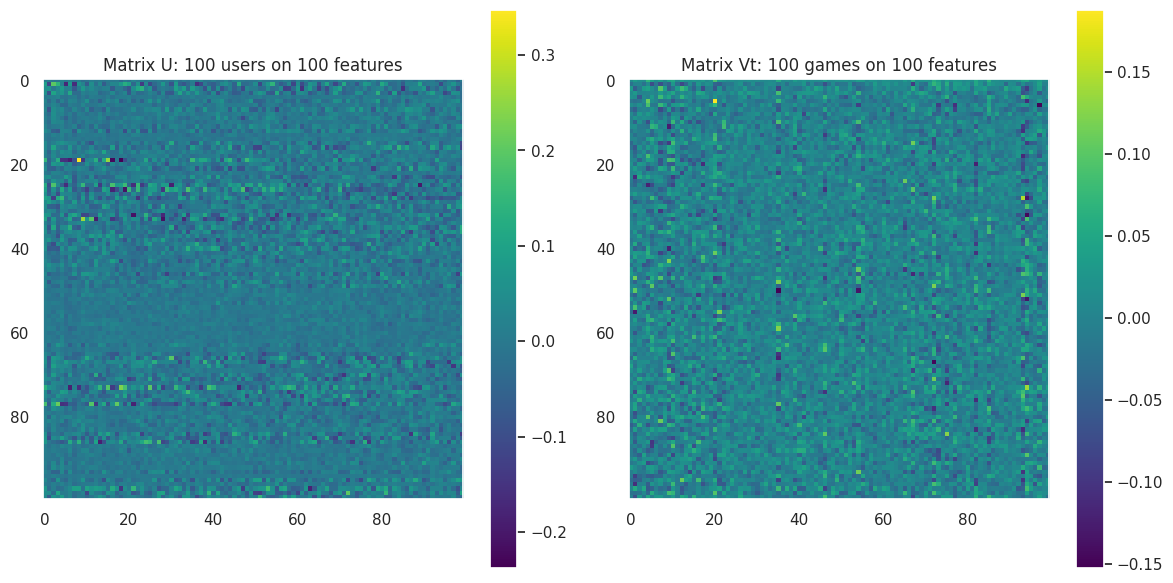

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Matrix U
im1 = ax[0].imshow(U[:100, :100], cmap="viridis")
ax[0].set_title("Matrix U: 100 users on 100 features")
ax[0].grid(False)
fig.colorbar(im1, ax=ax[0])

# Matrix Vt
im2 = ax[1].imshow(Vt[:100, :100], cmap="viridis")
ax[1].set_title("Matrix Vt: 100 games on 100 features")
ax[1].grid(False)
fig.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

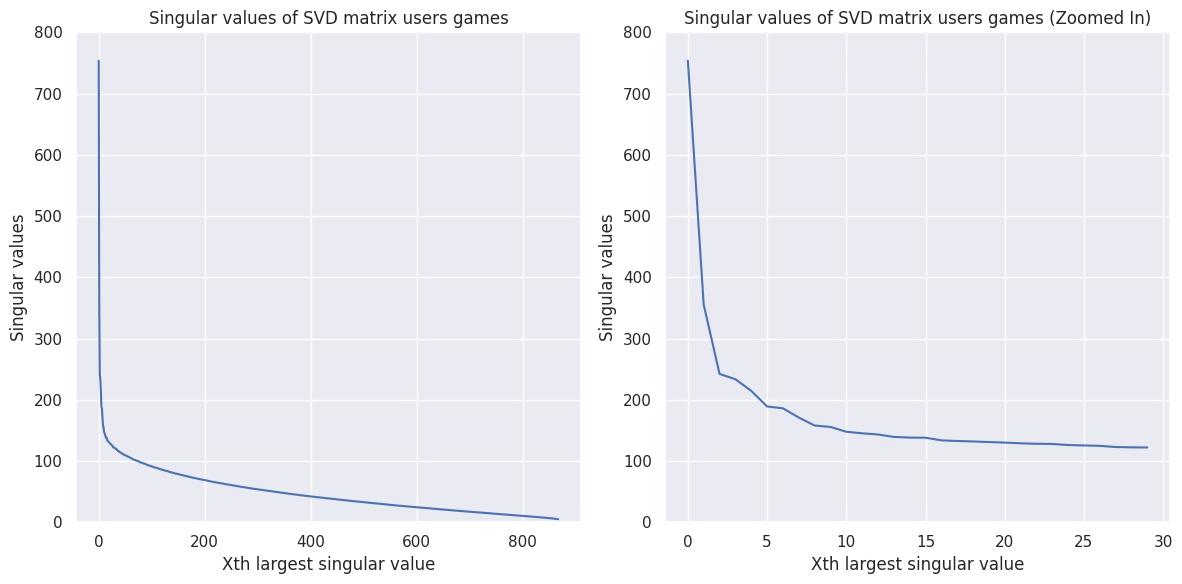

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# All singular values
sns.set_theme()
sns.lineplot(D, ax=ax[0])
ax[0].set_title("Singular values of SVD matrix users games")
ax[0].set_ylim(0, 800)
ax[0].set_xlabel("Xth largest singular value")
ax[0].set_ylabel("Singular values")

# Zoom in 
sns.set_theme()
sns.lineplot(D[:30], ax=ax[1])
ax[1].set_ylim(0, 800)
ax[1].set_title("Singular values of SVD matrix users games (Zoomed In)")
ax[1].set_xlabel("Xth largest singular value")
ax[1].set_ylabel("Singular values")

plt.tight_layout()
plt.savefig("images/SVD/sing_vals.png")
plt.show()


We can choose a `k` ranging from 5 to 20. Have to make tests for different k. Let's compare with SVD on sparse matrix.

In [329]:
# choosing k = 10, 10 best latent features
features = 20
Us, Ds, Vts = svds(user_game_ratings, k=features)
Us.shape, Ds.shape, Vts.shape, type(Us), type(Ds), type(Vts) # return nparray matrix

((868, 20), (20,), (20, 1135), numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [330]:
# Ds is in ascending order, but they are similar
np.allclose(Ds[::-1], D[:features])

True

**Visualisation of the components**

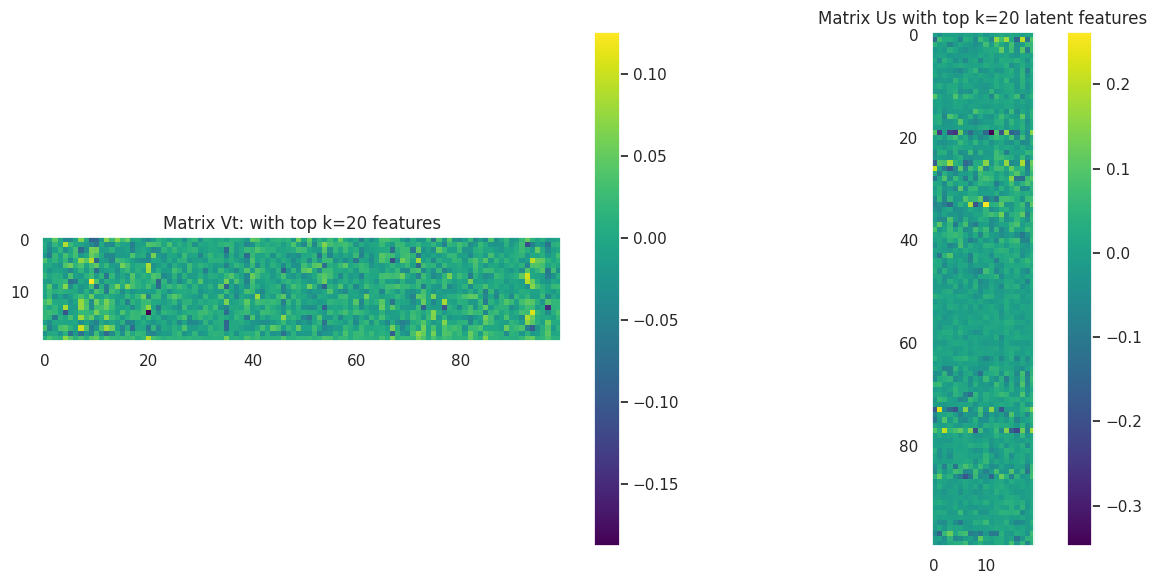

In [331]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Vts
im0 = ax[0].imshow(Vts[:, :100], cmap="viridis")
ax[0].set_title(f"Matrix Vt: with top k={features} features")
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])


# Plot Us
im1 = ax[1].imshow(Us[:100], cmap="viridis")
ax[1].set_title(f"Matrix Us with top k={features} latent features")
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

**Plotting using the 2 largest features**

In [332]:
# if i used k = 2 and plotted the data
Us, Ds, Vts = svds(user_game_ratings, k=2)
Us.shape, Ds.shape, Vts.shape

((868, 2), (2,), (2, 1135))

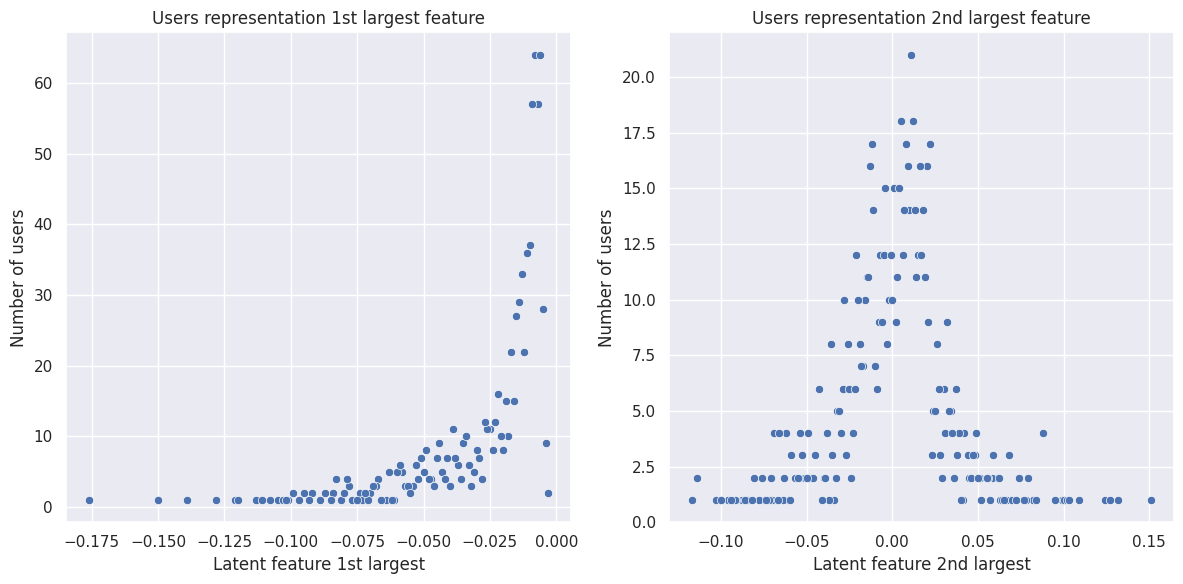

In [333]:
from collections import Counter

round_Us = np.array([[round(x[0],3), round(x[1], 3)] for x in Us])
feat2 = Counter(round_Us[:,0])
feat1 = Counter(round_Us[:,1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Users representation with the 1st best feature
# sns.scatterplot([pt[1] for pt in Us], ax=ax[0])
sns.scatterplot(x=feat1.keys(), y=feat1.values(), ax=ax[0])
ax[0].set_title("Users representation 1st largest feature")
ax[0].set_xlabel("Latent feature 1st largest")
ax[0].set_ylabel("Number of users")

# Users representation with the 2nd best feature
# sns.scatterplot([pt[0] for pt in Us], ax=ax[1])
sns.scatterplot(x=feat2.keys(), y=feat2.values(), ax=ax[1])
ax[1].set_title("Users representation 2nd largest feature")
ax[1].set_xlabel("Latent feature 2nd largest")
ax[1].set_ylabel("Number of users")

plt.tight_layout()
plt.show()


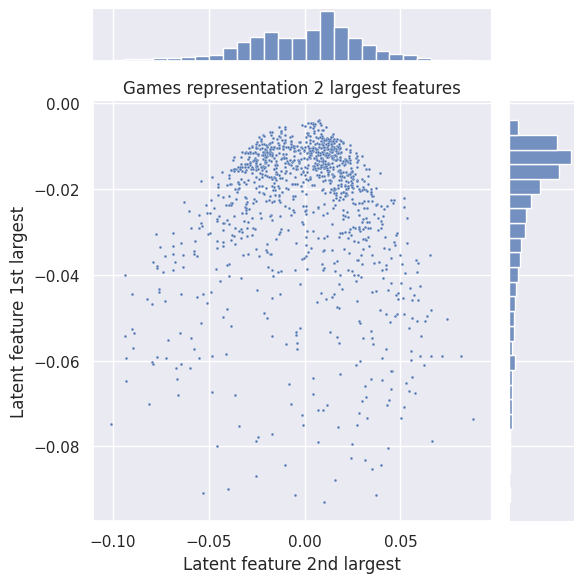

In [183]:
sns.jointplot(x=Vts[0], y=Vts[1], kind="scatter", s=4)
plt.title("Games representation 2 largest features")
plt.xlabel("Latent feature 2nd largest")
plt.ylabel("Latent feature 1st largest")

plt.tight_layout()
plt.show()

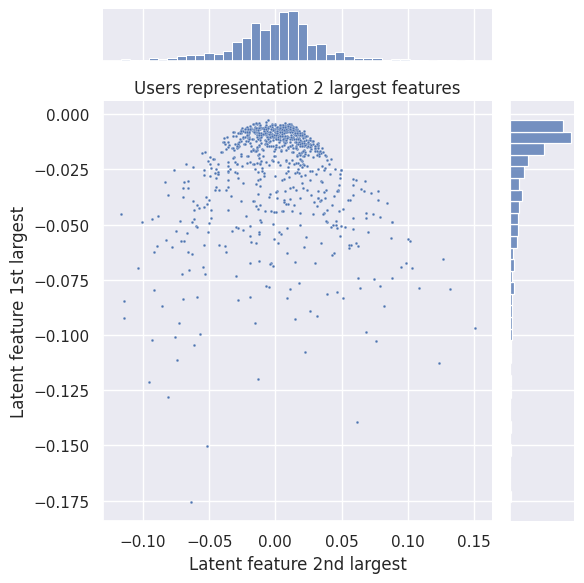

In [184]:
sns.jointplot(x=[pt[0] for pt in Us], y=[pt[1] for pt in Us], kind="scatter", s=4)
plt.title("Users representation 2 largest features")
plt.xlabel("Latent feature 2nd largest")
plt.ylabel("Latent feature 1st largest")

plt.tight_layout()
plt.show()

**Finding clusters?**

**With k create a similarity matrix Using U, for the users, based on their features**

In [321]:
features = 5
Us, Ds, Vts = svds(user_game_ratings, k=features)
Us.shape, Ds.shape, Vts.shape, np.unique(Us) # no Nan values

((868, 5),
 (5,),
 (5, 1135),
 array([-0.19903019, -0.18442717, -0.15409137, ...,  0.2054323 ,
         0.20884768,  0.21263696]))

In [322]:
# transform to sparse matrix
sparse_Us = csr_matrix(Us)
distances_eucl = euclidean_distances(sparse_Us)
distances_cos = cosine_distances(sparse_Us)
dis = cosine_distances(sparse_Us)

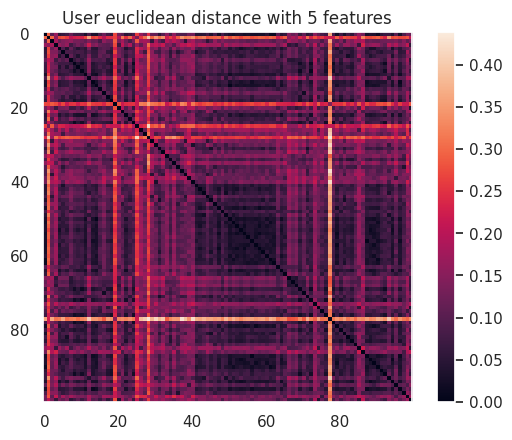

In [323]:
plt.imshow(distances_eucl[:100,:100])
plt.colorbar()
plt.title(f"User euclidean distance with {features} features")
plt.grid(False)
plt.show()

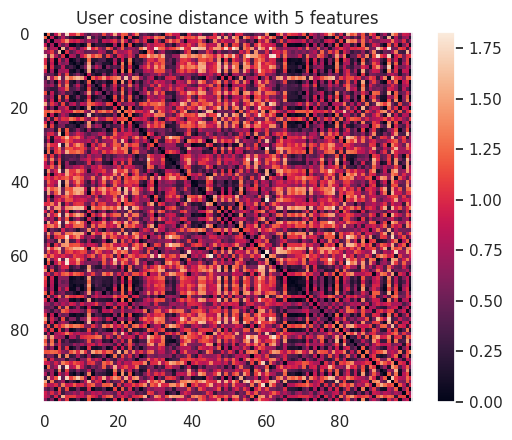

In [324]:
plt.imshow(distances_cos[:100,:100])
plt.colorbar()
plt.grid(False)
plt.title(f"User cosine distance with {features} features")
plt.show()

In [ ]:
# matrix similarity based on scores and matrix using features
similarity_matrix = calc_similarity_matrix(user_game_ratings, mask_ratings, 'cos')

# try to see if there are any differences in MAE

svd_mae_cos = np.array([])
mae_cos = np.array([])

for user in range(len(distances_cos)):
    mae_ratings = calc_error(user, user_game_ratings, mask_ratings, distances_cos ,"mae", "cos", 5)
    svd_mae_cos = np.append(svd_mae_cos,mae_ratings)

for user in range(len(distances_cos)):
    mae_ratings = calc_error(user, user_game_ratings, mask_ratings, similarity_matrix ,"mae", "cos", 5)
    mae_cos = np.append(mae_cos, mae_ratings)


In [335]:
np.mean(svd_mae_cos), np.mean(mae_cos)

(1.7054165919877278, 1.7069158573959158)

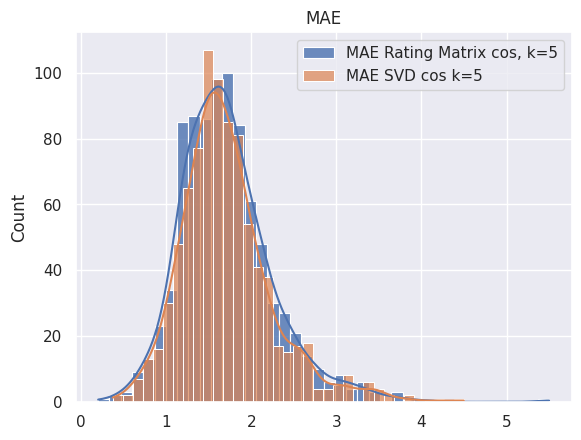

In [351]:
sns.histplot(mae_cos, label = "MAE Rating Matrix cos, k=5", kde= True, alpha = 0.8)
sns.histplot(svd_mae_cos, label = "MAE SVD cos k=5", kde= True, alpha = 0.7)
plt.title("MAE")
plt.legend()
plt.show()

In [360]:
# try to see if there are any differences in RMSE

svd_rmse_cos = np.array([])
mae_rmse = np.array([])

for user in range(len(distances_cos)):
    rmse_ratings = calc_error(user, user_game_ratings, mask_ratings, distances_cos ,"rmse", "cos", 5)
    svd_rmse_cos = np.append(svd_rmse_cos,rmse_ratings)

for user in range(len(distances_cos)):
    rmse_ratings = calc_error(user, user_game_ratings, mask_ratings, similarity_matrix ,"rmse", "cos", 5)
    mae_rmse = np.append(mae_rmse, rmse_ratings)


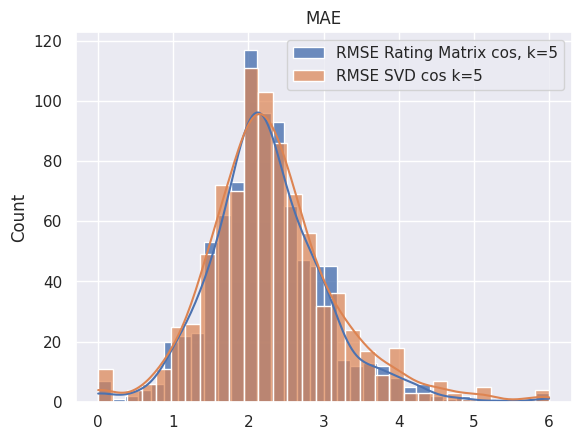

In [365]:
sns.histplot(mae_rmse, label = "RMSE Rating Matrix cos, k=5", kde= True, alpha = 0.8)
sns.histplot(svd_rmse_cos, label = "RMSE SVD cos k=5", kde= True, alpha = 0.7)
plt.title("MAE")
plt.legend()
plt.show()

In [366]:
np.mean(mae_rmse), np.mean(svd_rmse_cos)

(nan, nan)